In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention,Lambda

In [2]:
!curl -s -o flower.jpeg https://images.unsplash.com/photo-1604085572504-a392ddf0d86a?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=224&q=224

Shape of image is :  (224, 224, 3)


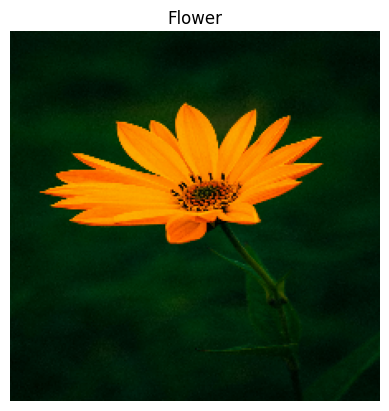

In [3]:
img=plt.imread("/content/flower.jpeg")
# resizing to 224 * 224
img=tf.image.resize(tf.convert_to_tensor(img),(224,224))
print("Shape of image is : ",img.shape)
plt.imshow(img.numpy().astype("uint8"))
plt.title("Flower")
plt.axis("off")
plt.show()

In [4]:
# layer to extract patches
class PatchExtractor(Layer):
  def __init__(self):
    super().__init__()

  def call(self,images):
    batch_size=tf.shape(images)[0]
    patches=tf.image.extract_patches(images,sizes=[1,16,16,1],strides=[1,16,16,1],rates=[1,1,1,1],padding="VALID")
    # print(tf.shape(patches))
    patch_dim=patches.shape[-1]
    patches=tf.reshape(patches,[batch_size,-1,patch_dim])
    # print(tf.shape(patches))
    return patches

In [5]:
# creating 1 image as batch for testing
batch=tf.expand_dims(img,axis=0)
print(tf.shape(batch))
img_patches=PatchExtractor()(batch)
print(tf.shape(img_patches))

tf.Tensor([  1 224 224   3], shape=(4,), dtype=int32)
tf.Tensor([  1 196 768], shape=(3,), dtype=int32)


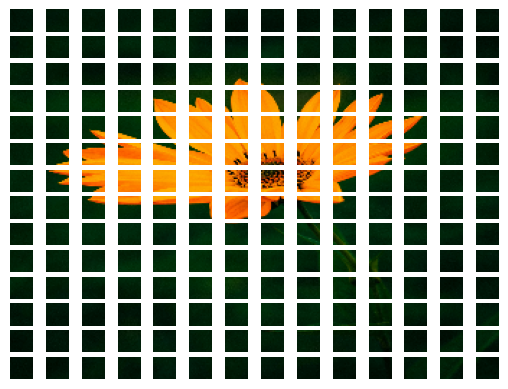

In [6]:
# visualising patches
for i in range(1,197):
  plt.subplot(14,14,i)
  t_img=img_patches[0,i-1]
  t_img=tf.reshape(t_img,[16,16,3])
  plt.imshow(t_img.numpy().astype("uint8"))
  plt.axis("off")
plt.show()

In [9]:
class PatchEncoder(Layer):
  def __init__(self,num_patches=196,projection_dim=768):
    super().__init__()
    self.num_patches=num_patches
    self.projection_dim=projection_dim

    w_init=tf.random_normal_initializer()
    class_token=w_init(shape=[1,projection_dim],dtype="float32")
    self.class_token=tf.Variable(initial_value=class_token,trainable=True)

    self.projection=Dense(units=projection_dim)

    self.position_embedding=Embedding(input_dim=num_patches+1,output_dim=projection_dim)

  def call(self,patches):
    batch_size=tf.shape(patches)[0]
    # class token
    class_token=tf.tile(self.class_token,[batch_size,1])
    class_token=tf.reshape(class_token,[batch_size,1,self.projection_dim])

    # embed
    proj=self.projection(patches)
    proj=tf.concat([class_token,proj],axis=1)

    # positional embedding
    positions=tf.range(start=0,limit=self.num_patches+1,delta=1)
    pos_embed=self.position_embedding(positions)

    return proj+pos_embed

In [16]:
# trying shape
encoder=PatchEncoder()
embeddings=encoder(img_patches)
print(tf.shape(embeddings))

tf.Tensor([  1 197 768], shape=(3,), dtype=int32)


In [11]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [14]:
class Block(Layer):
  def __init__(self,projection_dim, num_heads=4,dropout_rate=0.1):
    super().__init__()
    self.projection_dim=projection_dim
    self.num_heads=num_heads

    self.layernorm1=LayerNormalization()
    self.layernorm2=LayerNormalization()

    self.multihead_attention=MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
    self.mlp=MLP(projection_dim*2,projection_dim,dropout_rate)

  def call(self,inputs):
    x=self.layernorm1(inputs)
    attention_output=self.multihead_attention(x,x)
    x=Add()([inputs+attention_output])
    x=self.layernorm2(x)
    mlp_output=self.mlp(x)
    x=Add()([x+mlp_output])
    return x

In [15]:
block = Block(768)
y = block(tf.zeros((1, 197, 768)))
y.shape

TensorShape([1, 197, 768])

In [17]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=4, num_blocks=12, dropout_rate=0.1):
        super().__init__()
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        self.norm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.5)

    def call(self, x):
        # Create a [batch_size, projection_dim] tensor.
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        y = self.dropout(x)
        return y

In [18]:
transformer = TransformerEncoder(768)
y = transformer(embeddings)
y.shape

TensorShape([1, 197, 768])

In [20]:
def create_VisionTransformer(num_classes, num_patches=196, projection_dim=768, input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)

    # cls token
    cls_representation = Lambda(lambda x: x[:, 0])(representation)

    logits = MLP(projection_dim, num_classes, 0.5)(cls_representation)
    # Create model
    model = Model(inputs=inputs, outputs=logits)
    return model

In [21]:
model = create_VisionTransformer(2)

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_extractor_1               │ (None, None, 768)      │             0 │
│ (PatchExtractor)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder_3 (PatchEncoder)  │ (None, 197, 768)       │       741,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 197, 768)       │   141,743,616 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_25 (MLP)                    │ (None, 2)              │       592,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,077,634 (545.80 MB)

 Trainable params: 143,077,634 (545.80 MB)

 Non-trainable params: 0 (0.00 B)